# Enseñando a un agente a jugar al Blackjack

Usaremos el método de Monte Carlo para políticas $\varepsilon$-suaves para encontrar una política óptima con la que jugar al blackjack. Para ello usaremos la API de [OpenAI Gym](https://www.gymlibrary.ml/) y asumiremos que el crupier sigue la política 17 *soft*, es decir, pedirá cartas siempre que sus cartas sumen menos de 17 y se plantará en 17 o más.

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt 
from collections import defaultdict
from time import time

## Definición del agente
Lo primero que haremos será definir la clase `Agent` que almacenará toda la información relevante sobre el agente.

In [2]:
class Agent():

    # eps      : Grado de exploración
    # gamma    : Tasa de descuento
    # nActions : Tamaño del espacio de acciones
    def __init__(self, eps = 0.1, gamma = 1, nActions = 2):
        self.eps = eps
        self.gamma = gamma
        self.nActions = nActions

        # pi : Diccionario que determinará cual es la acción voraz para cada estado
        # Q  : Diccionario que almacenrá la función de valor para los pares estado-acción
        self.pi = defaultdict(lambda: 0)
        self.Q = defaultdict(lambda: 0)

    # La función e_greedy(state) recibe un estado y devuelve la acción que deberá realizar
    # el agente siguiendo una política epsilón-voraz
    def e_greedy(self, state):
        if np.random.random() < self.eps:
            action = env.action_space.sample()
        else:
            action = self.pi[state]
        return action

    # La función greedyAction(state) calcula dado un estado cual es la acción voraz según
    # la aproximación de Q actual
    def greedyAction(self, state):
        values = [self.Q[state,action] for action in range(self.nActions)]
        return np.argmax(values)

    # La función episodeSample() ejecuta un episodio completo, es decir, juega una partida
    # de blackjack completa y devuelve los pares estado-acción experimentados así como
    # las recompensas obtenidas
    def episodeSample(self):
        stateActionPairs = []
        rewards = []

        state = env.reset()

        done = False
        while not done:
            action = self.e_greedy(state)
            stateActionPairs.append((state,action))

            state, reward, done, _ = env.step(action)

            rewards.append(reward)

        return stateActionPairs, rewards

## Definición del entramiento del agente

Una vez definido el comportamiento del agente simplemente debemos de implementar el método de Monte Carlo que queremos y lo ejecutamos mientras no se cumpla la condición de parada. En este caso la condición de parada es que se visiten todos los pares estado-acción al menos `threshold` veces, donde `threshold` es una variable que podemos pasarle a la función `run`.

In [3]:
def run(env = gym.make("Blackjack-v1",sab=True), agent = Agent(), threshold = 1000):
    # Hay un total de 560 pares estados-acción, iremos contando cuantos de ellos se han
    # visitado al menos threshold veces
    visitedStates = 0

    # counts es el diccionario que nos ayudará a almacenar la cantidad de veces que se 
    # ha visitado un par estado-acción
    counts = defaultdict(lambda: 0)

    nEpisodes = 1
    t0 = time()

    # Mientras no se hayan visitado al menos threshold veces los 560 pares seguiremos
    # entrenando al agente 
    while visitedStates < 560:
        stateActionPairs, rewards = agent.episodeSample()
        G = 0

        for t in range(len(stateActionPairs))[::-1]:
            G = agent.gamma * G + rewards[t]

            if stateActionPairs[t] not in stateActionPairs[:t]:
                stateActionPair = stateActionPairs[t]
                state, action = stateActionPairs[t]
                agent.Q[stateActionPair] = (agent.Q[stateActionPair]*counts[stateActionPair] + G)/(counts[stateActionPair] + 1)

                greedyAction = agent.greedyAction(state)
                agent.pi[state] = greedyAction
                
                counts[stateActionPair] += 1
                # Una vez un par se ha visitado threshold veces se hace un print para
                # saber como va avanzando el entrenamiento
                if counts[stateActionPair] == threshold:
                    visitedStates += 1
                    print("\r[%.2fs] Pares estado-acción completos %i/560 (Número total de episodios %i) --> Último par estado-acción completo %s" \
                          %(time()-t0,visitedStates,nEpisodes,stateActionPair), end="", flush=True)

        nEpisodes += 1

    print("\nEntrenamiento terminado en %.2fs y tras %i episodios."%(time()-t0,nEpisodes))
    
    return counts

Una vez definida todas las funciones necesarias solo queda crear el entorno de trabajo en Gym, crear el agente y entrenarlo.

In [4]:
env = gym.make("Blackjack-v1",sab=True)
agent = Agent()
counts = run(env,agent,1000)

[3126.90s] Pares estado-acción completos 560/560 (Número total de episodios 47090703) --> Último par estado-acción completo ((12, 4, True), 0)
Entrenamiento terminado en 3126.90s y tras 47090704 episodios.


El entrenamiento dura unos 50 minutos en mi ordenador.

## Representación de la política obtenida
Por último la función `graphs` nos permite representar graficamente la política obtenida.

In [5]:
def graphs(agent, save=False):
    pi = agent.pi
    
    usable_HIT = [state[:2] for state in pi.keys() if state[2] and pi[state] == 1]
    usable_HIT = list(map(lambda a: (max([b[0] for b in usable_HIT if b[1] == a]),a),range(1,11)))
    usable_x = [pair[1] for pair in usable_HIT]
    usable_y = [pair[0] for pair in usable_HIT]

    noUsable_HIT = [state[:2] for state in pi.keys() if not state[2] and pi[state] == 1]
    noUsable_HIT = list(map(lambda a: (max([b[0] for b in noUsable_HIT if b[1] == a]),a),range(1,11)))
    noUsable_x = [pair[1] for pair in noUsable_HIT]
    noUsable_y = [pair[0] for pair in noUsable_HIT]

    fig1, ax1 = plt.subplots(1,1,figsize=(5,5))
    ax1.set_facecolor("indianred")
    ax1.bar(usable_x,usable_y,width=1,color='seagreen')
    ax1.set_ylim([10,21]);
    ax1.set_xlim([0.5,10.5]);
    ax1.set_xticks(range(1,11));
    ax1.set_yticks(range(10,22));
    ax1.text(4.15,18.75,"STICK",fontsize=20);
    ax1.text(4.75,13.5,"HIT",fontsize=20);
    ax1.set_xlabel("Suma cartas crupier",fontsize=16)
    ax1.set_ylabel("Suma cartas jugador",fontsize=16)
    if save:
        plt.savefig("usable.png",format="png",dpi=600)

    fig2, ax2 = plt.subplots(1,1,figsize=(5,5))
    ax2.set_facecolor("indianred")
    # Normalmente hay 2 pares para los que se obtienen resultados distintos a los presentados
    # en Reinforcement Learning de Richard S. Sutton y Andrew G. Barto, por lo que los 
    # recalcaremos en azul
    ax2.bar(3,12,width=1,color='lightsteelblue')
    ax2.bar(10,16,width=1,color='lightsteelblue')
    ax2.bar(noUsable_x,noUsable_y,width=1,color='seagreen')
    ax2.set_ylim([10,21]);
    ax2.set_xlim([0.5,10.5]);
    ax2.set_xticks(range(1,11));
    ax2.set_yticks(range(10,22));
    ax2.text(3,17.25,"STICK",fontsize=20);
    ax2.text(7.85,13,"HIT",fontsize=20);
    ax2.set_xlabel("Suma cartas crupier",fontsize=16)
    ax2.set_ylabel("Suma cartas jugador",fontsize=16)
    if save:
        plt.savefig("noUsable.png",format="png",dpi=600)

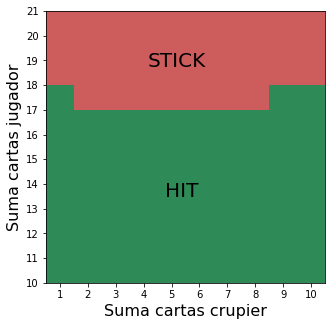

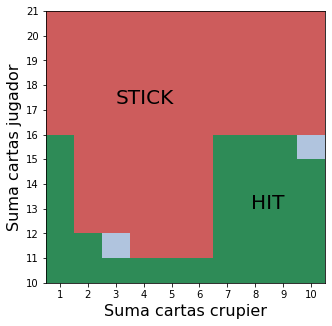

In [6]:
graphs(agent)